In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 1. Overview

Bidirectional Embedding Representations from Transformers (BERT), is a method of pre-training language representations which obtains state-of-the-art results on a wide array of Natural Language Processing (NLP) tasks. 

The original paper can be found here: https://arxiv.org/abs/1810.04805.

NVIDIA's BERT 19.10 is an optimized version of Google's official implementation, leveraging mixed precision arithmetic and tensor cores on V100 GPUS for faster training times while maintaining target accuracy.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## 2. Requirements

### 2.a GPU

Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.

This demo will work on any NVIDIA GPU with CUDA cores, though for improved FP16 inference, a Volta, Turing or newer generation GPU with Tensor cores is desired.  On Google Colab, this normally means a T4 GPU. If you are assigned an older K80 GPU, another trial at another time might give you a T4 GPU.

Guys, we will use Hugging face transformers in pytorch  you can see more [here](https://huggingface.co/transformers/)
# Hugging Face Transformers
The [Hugging Face Transformers](https://huggingface.co/transformers/#) package provides state-of-the-art general-purpose architectures for natural language understanding and natural language generation. They host dozens of pre-trained models operating in over 100 languages that you can use right out of the box. All of these models come with deep interoperability between PyTorch and Tensorflow 2.0, which means you can move a model from TF2.0 to PyTorch and back again with just a line or two of code!


If you're new to Hugging Face, I strongly recommend working through the HF [Quickstart guide](https://huggingface.co/transformers/quickstart.html) as well as their excellent [Transformer Notebooks](https://huggingface.co/transformers/notebooks.html) (I did!), as I won't cover that material in this notebook.

In [ ]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
%cd /content/drive/MyDrive/Bert-RA/data1

/content/drive/MyDrive/Bert-RA/data1


## 3. BERT Inference: Question Answering

We can run inference on a fine-tuned BERT model for tasks like Question Answering.

Here we use a BERT model fine-tuned on a [SQuaD 2.0 Dataset](https://rajpurkar.github.io/SQuAD-explorer/) which contains 100,000+ question-answer pairs on 500+ articles combined with over 50,000 new, unanswerable questions.
One of the most canonical datasets for QA is the Stanford Question Answering Dataset, or SQuAD, which comes in two flavors: SQuAD 1.1 and SQuAD 2.0. These reading comprehension datasets consist of questions posed on a set of Wikipedia articles, where the answer to every question is a segment (or span) of the corresponding passage. In SQuAD 1.1, all questions have an answer in the corresponding passage. SQuAD 2.0 steps up the difficulty by including questions that cannot be answered by the provided passage. 
Copy files and upload in drive
https://drive.google.com/drive/folders/1B5BrkBx1K15e5KxUl2XqCYXoRQ5Kib3H?usp=sharing

In [ ]:
%ls

cache_validation      nbest_predictions.json  train-v2.0.json
cache_validation.zip  null_odds.json          utils_squad_evaluate.py
checkpoint-50/        predictions.json        utils_squad.py
checkpoint-final/     __pycache__/
dev-v2.0.json         results.json


In [ ]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_file = 'train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [ ]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


## BERT Input Format
To feed a QA task into BERT, we pack both the question and the reference text into the input.

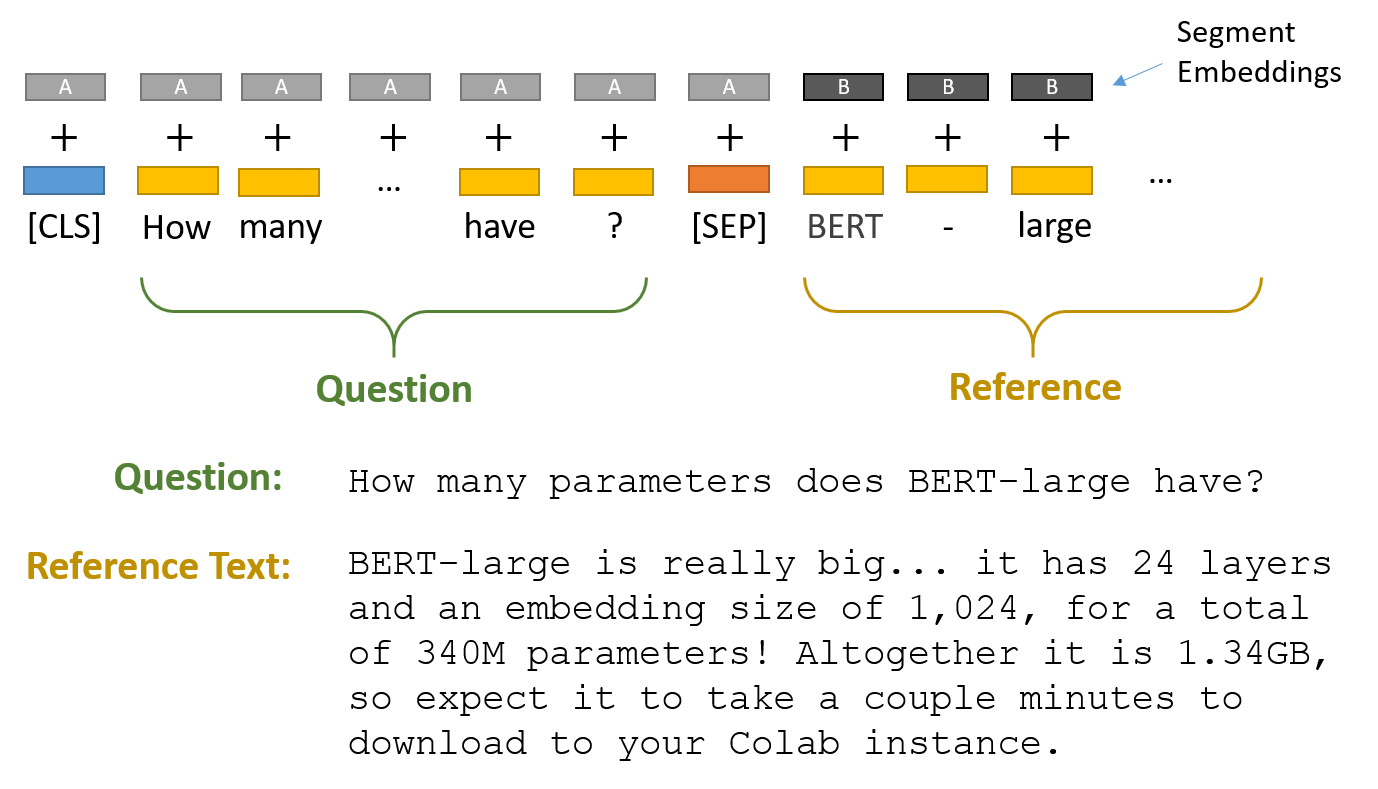

The two pieces of text are separated by the special `[SEP]` token. 

BERT also uses "Segment Embeddings" to differentiate the question from the reference text. These are simply two embeddings (for segments "A" and "B") that BERT learned, and which it adds to the token embeddings before feeding them into the input layer. 

In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
117139,5730a771069b531400832209,How long was there native Sumerian rule during...,"[Native, Sumerian, rule, re-emerged, for, abou...",about a century,5,7,False
117140,5730a771069b53140083220a,When was the Third Dynasty of Ur?,"[Native, Sumerian, rule, re-emerged, for, abou...",approximately 2100-2000 BC,19,21,False
117141,5730a771069b53140083220b,What language was in use in the Neo-Sumerian E...,"[Native, Sumerian, rule, re-emerged, for, abou...",Akkadian,24,24,False
117142,5730a771069b53140083220c,What is considered to be the world's first city?,"[Native, Sumerian, rule, re-emerged, for, abou...",Eridu,34,34,False
117143,5730a771069b53140083220d,How many cultures may have fused together in E...,"[Native, Sumerian, rule, re-emerged, for, abou...",three,52,52,False
117144,5a64f832c2b11c001a425b57,What Empire was followed by native Sumerian rule?,"[Native, Sumerian, rule, re-emerged, for, abou...",,-1,-1,True
117145,5a64f832c2b11c001a425b58,What dynasty was in power from the 21st to the...,"[Native, Sumerian, rule, re-emerged, for, abou...",,-1,-1,True
117146,5a64f832c2b11c001a425b59,What was the worlds first settlement?,"[Native, Sumerian, rule, re-emerged, for, abou...",,-1,-1,True
117147,5a64f832c2b11c001a425b5a,How many cultures could be found in Arabia at ...,"[Native, Sumerian, rule, re-emerged, for, abou...",,-1,-1,True


In [ ]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
Continuing his experiments in Brantford, Bell brought home a working model of his telephone.
On August 3, 1876, from the telegraph office in Mount Pleasant five miles (eight
km) away from Brantford, Bell sent a tentative telegram indicating that he was ready.
With curious onlookers packed into the office as witnesses, faint voices were heard replying.
The following night, he amazed guests as well as his family when a message
was received at the Bell home from Brantford, four miles (six km) distant, along
an improvised wire strung up along telegraph lines and fences, and laid through a
tunnel. This time, guests at the household distinctly heard people in Brantford reading and
singing. These experiments clearly proved that the telephone could work over long distances.
QUESTION:                                                                                            ANSWER:
From what city did Bell send his first message?                                                      Mou

In [ ]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)## get the length of 'doc_tokens'
train_data['question_len'] = train_data['question_text'].apply(len)## get the length of 'question_text' here
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
99146,5ace6d0932bba1001ae4a675,What type of doctors work at the Guam Regional...,"[The, Government, of, Guam, maintains, the, is...",,-1,-1,True,79,60
10201,5ad387dc604f3c001a3fe56f,Which type of power is vested in Congress?,"[Judicial, power—the, power, to, decide, cases...",,-1,-1,True,83,42
5314,56d1cf79e7d4791d0090220b,What does arupyadhatu mean?,"[The, above, are, further, subdivided, into, 3...",formless realms,42,43,False,61,27
8951,5a7fd4e18f0597001ac000db,What is the type of symbiotic relationship whe...,"[Some, symbiotic, relationships, are, obligate...",,-1,-1,True,48,108
27760,56fb7b7f8ddada1400cd6451,What did peasant women do when it was time for...,"[Women, in, the, Middle, Ages, were, officiall...",help with field-work,88,90,False,170,59


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


## Start & End Token Classifiers
BERT needs to highlight a "span" of text containing the answer--this is represented as simply predicting which token marks the start of the answer, and which token marks the end.

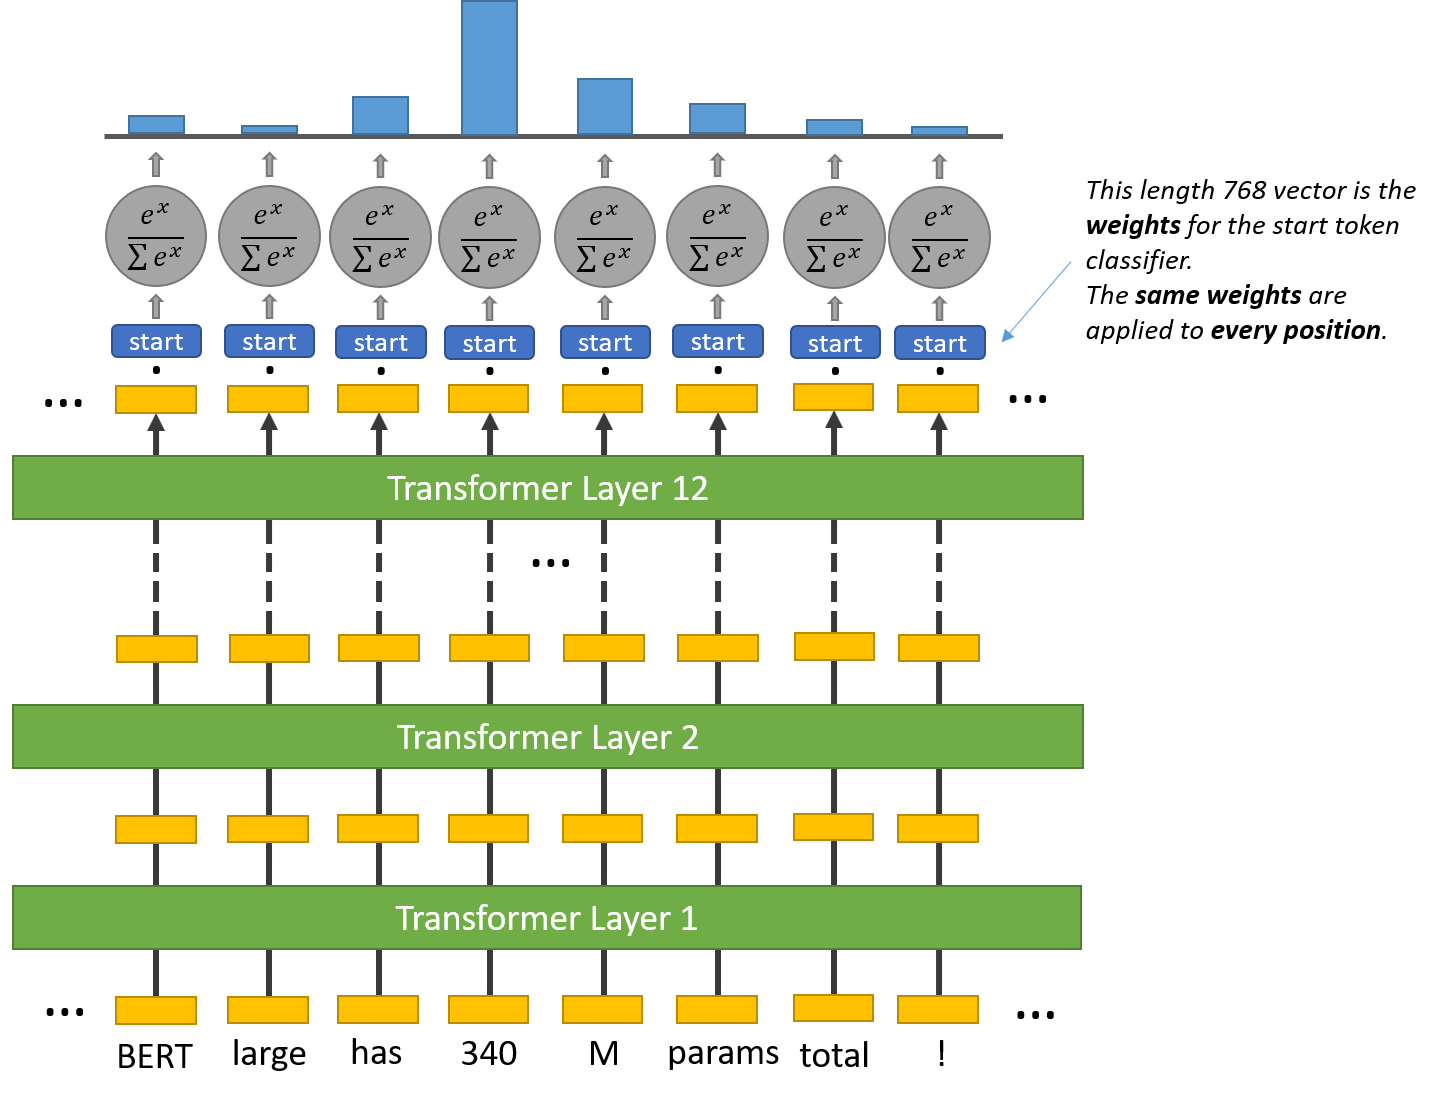

For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue "start" rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the 'start' weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

We repeat this process for the end token--we have a separate weight vector this.

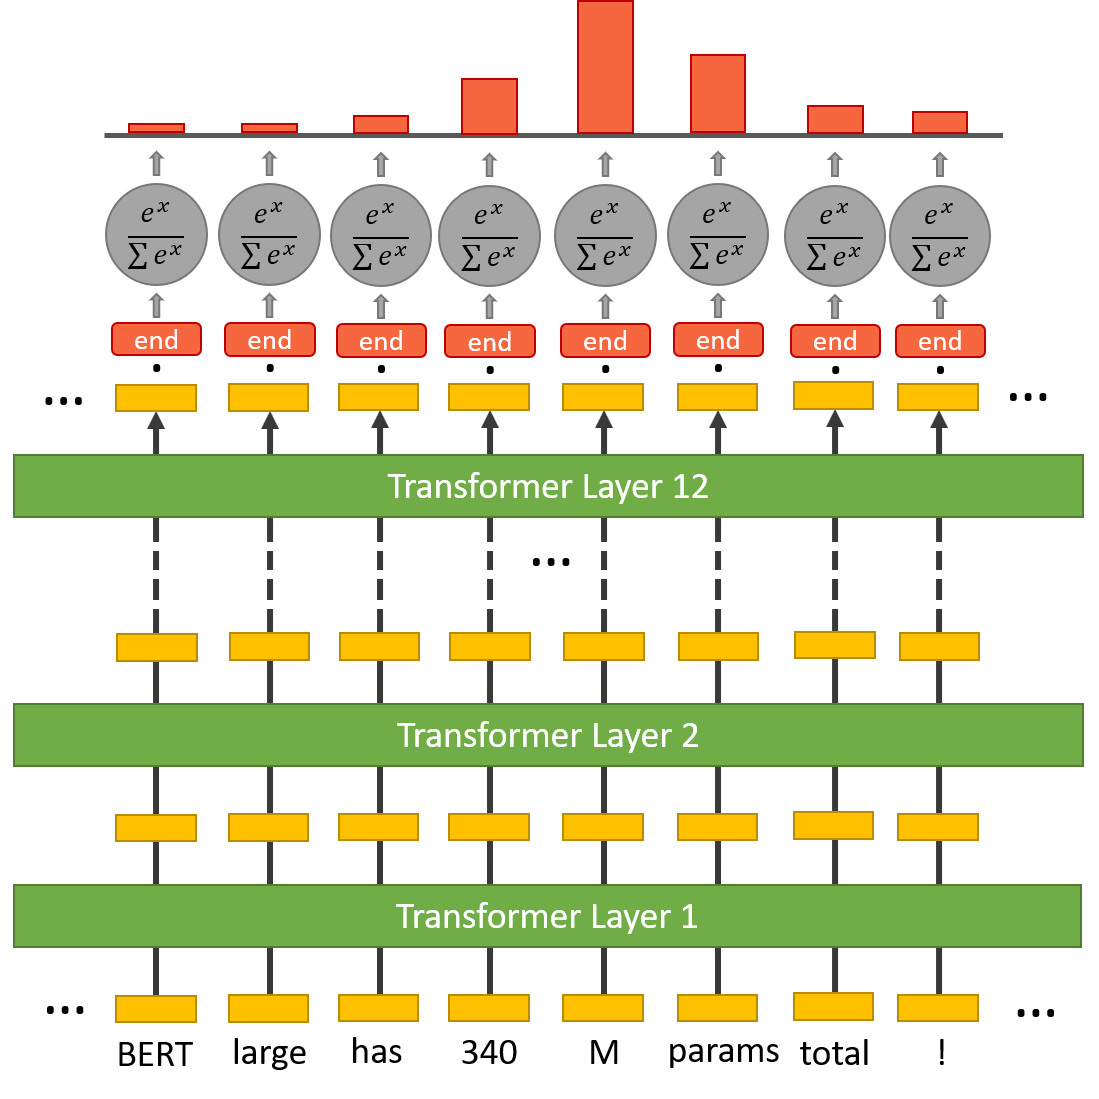

In [ ]:
model = 'bert-large-uncased' ## choose model https://huggingface.co/models like you can choose basic models such as 'bert-base-uncased' or 'bert-large-uncased' or others

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size =32  # choose 4 - 64

In [ ]:
cached_features_file = 'cache_train'

In [ ]:
len(examples)

130319

In [ ]:
print(train_data.shape)


(130319, 9)


In [ ]:
examples =examples[:10000]## choose first 1000 or 10000 more depending on percentage of train data


In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  # torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)## similarly convert tensor for input mask
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)## similarly convert tensor for segment ids
all_cls_index =torch.tensor([f.cls_index for f in features], dtype=torch.long) ## similarly convert tensor for cls index
all_p_mask = torch.tensor([f.p_mask  for f in features], dtype=torch.float)## similarly convert tensor for p mask

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)## similarly convert tensor for start position
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)## similarly convert tensor for end position
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
import glob
checkpoints = sorted(glob.glob('checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

### Pick a Model
Not every Transformer architecture lends itself naturally to the task of question answering. For example, GPT does not do QA; similarly BERT does not do machine translation.  HF identifies the following model types for the QA task: 

- BERT
- distilBERT 
- ALBERT
- RoBERTa
- XLNet
- XLM
- FlauBERT


I'll stick with the now-classic BERT model in this notebook, but feel free to try out some others (I will - and I'll let you know when we do).

In [ ]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = 'checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-large-uncased')  ## choose model https://huggingface.co/models like you can choose basic models such as 'bert-base-uncased' or 'bert-large-uncased' or others

model.cuda()

Loading model from checkpoint checkpoint-50


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0308,  0.0037,  0.0330,  ..., -0.0078, -0.0089, -0.0179],
        [-0.0359, -0.0039, -0.0379,  ..., -0.0014,  0.0230,  0.0007]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([7.0734e-06, 1.5444e-05], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 1e-4  ## choose between 1e3 to 1e5
adam_epsilon= 1e-9## choose between 1e8 1e9
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

### Fine-tuning script

We've chosen a model and we've got some data. Time to train!

All the standard models that HF supports have been pre-trained, which means they've all been fed massive unsupervised training sets in order to learn basic language modeling. In order to perform well at specific tasks (like question answering), they must be trained further -- fine-tuned -- on specific datasets and tasks.


HF helpfully provides a script that fine-tunes a Transformer model on one of the SQuAD datasets, called `run_squad.py`. You can grab the script [here](https://github.com/huggingface/transformers/blob/master/examples/question-answering/run_squad.py)

In [ ]:
num_train_epochs = 1 ## choose 1 to 3 

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader)// num_train_epochs ))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < int(global_step) + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step+ = 1
    
      if global_step %50 == 0: 
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

SyntaxError: ignored

In [ ]:
output_dir = 'checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
train_loss_set_ckpt = torch.load('checkpoint-50/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [ ]:
input_file = 'dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = 'dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "predictions.json"
  output_nbest_file = "nbest_predictions.json"
  output_null_log_odds_file = "null_odds.json"
  output_dir = "predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)

In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

**Evaluate on any text**